In [30]:
import numpy as np
import sympy as sp
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simps
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar

# Given data
q_l0 = 38.7 #[kW/m] Peak linear power
t_cycle = 360 #[days] Length of cycle

# Neutronic specifications
phi_0 = 6.1e15 #[n/cm^2/s] Neutron flux at peak power

# Thermo-hydraulic specifications
pitch = 8.275 #[mm] Pin pitch
T_co_in_C = 395 #[°C] Coolant inlet temperature
P_co_in = 0.1 #[MPa] Coolant inlet pressure
m_co_in = 0.049 #[kg/s] Coolant mass flow rate

# Fuel pin specifications
H_act = 850 #[mm] Fuel column height
D_fuel_out = 5.42 #[mm] Fuel pellet outer diameter
H_fuel = 7 #[mm] Fuel pellet height
TD_fuel = 11.31 #[g/cm^3] Fuel theoretical density
rho_fuel = 0.945*TD_fuel #[g/cm^3] Fuel density %TD
D_grain = 10 #[10^-6 m] Fuel grain diameter
r_OM = 1.957 #[O/M] Oxygen to metal ratio
D_clad_out = 6.55 #[mm] Cladding outer diameter
P_gas_0 = 0.1 #[MPa] Initial pressure of filling gas
T_gas_0 = 20 #[°C] Initial temperature of filling gas

In [31]:
# Calculation of burnup
N_pellet = math.floor((H_act/H_fuel)) #[/] Number of pellets per column
V_pellet = np.pi*(D_fuel_out**2)/4*H_fuel #[mm^3] Volume of a single pellet
rho_fuel = 0.945*TD_fuel*1e3 #[kg/m^3] Fuel density %TD
V_fuel = N_pellet*V_pellet*1e-9 #[m^3] Total fuel volume per fuel rod
m_HM = rho_fuel*V_fuel/1000 #[ton-HM] Weight of fuel material per fuel rod
beta = (q_l0/1e6)*(H_act/1000)*t_cycle/m_HM #[GWd/t_HM]

print("Number of pellets per fuel rod:", N_pellet, ".")
print("Volume of pellet:",V_pellet, "[mm^3].")
print("Weight of fuel material per fuel rod:",m_HM, "[ton].")
print("Burnup of fuel:",beta, "[GWd/t-HM].")

Number of pellets per fuel rod: 121 .
Volume of pellet: 161.5051942506016 [mm^3].
Weight of fuel material per fuel rod: 0.0002088652923477768 [ton].
Burnup of fuel: 56.69778768356509 [GWd/t-HM].


The first task was to find an explicit expresion for the linear power as a function of z.

The linear power for a symmetric system is:

\begin{equation}
q_l(z) = q_{l0} \cdot cos(\frac{\pi z}{H_{ext}})
\end{equation}

Where,

- $q_{l0}$ is the peak power at the midplane of the fuel pin (z=0). It is assumed that the given peak power is located in the outer surface of the cladding, i.e., $q_{l0} = 38.7 [kW/m]$ when r = $r_{clad,out}$.

- $H_{ext}$ is the extrapolated boundary in [m].

Given that the nodalization for the peak power factors corresponds to a range and not a single value of "z". The fitted curve is valid when it crosses the top of the histogram.

Extrapolated boundary (H_ext): 1.21 [m]


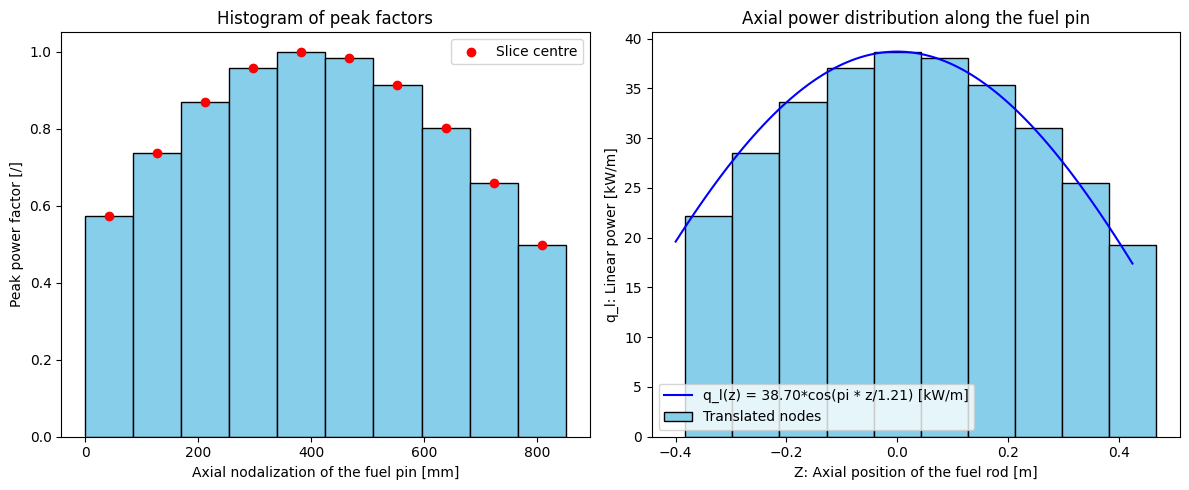

In [32]:
# Axial nodalization of fuel pin
H_nod = np.array([42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5]) #[mm] Center of slice from bottom
H_nod_c = (H_nod - 382.5) / 1000 #[m] Corrected position of nodes from center of fuel pin
q_nod_f = np.array([0.572, 0.737, 0.868, 0.958, 1.000, 0.983, 0.912, 0.802, 0.658, 0.498]) #[/] Peak power factors

# Define a symmetric peak power function along the fuel pin
def q_l_f(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Extrapolated boundary
initial_guess = [1]  # Initial guess for H_ext
H_ext_opt, _ = curve_fit(q_l_f, H_nod_c, q_l0*q_nod_f, p0 = initial_guess)
H_ext = H_ext_opt[0] # [m] Optimized extrapolated boundary
print(f"Extrapolated boundary (H_ext): {H_ext:.2f} [m]")

# Plot the results
z_fit = np.linspace(-0.4, max(H_nod_c), 100)
q_fit = q_l_f(z_fit, H_ext_opt[0])

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of the given peak factor power vs height from bottom
ax1.bar(H_nod, q_nod_f, width=85, color='skyblue', edgecolor='black')
ax1.scatter(H_nod, q_nod_f, label="Slice centre", color="red")
ax1.set_title('Histogram of peak factors')
ax1.set_xlabel('Axial nodalization of the fuel pin [mm]')
ax1.set_ylabel('Peak power factor [/]')
ax1.legend()

# Validation of the fitted function
ax2.bar(H_nod_c, q_l0*q_nod_f, width=0.085, label = 'Translated nodes',color='skyblue', edgecolor='black')
ax2.plot(z_fit, q_fit, label=f"q_l(z) = {q_l0:.2f}*cos(pi * z/{H_ext:.2f}) [kW/m]", color="blue")
ax2.set_title('Axial power distribution along the fuel pin')
ax2.set_xlabel("Z: Axial position of the fuel rod [m]")
ax2.set_ylabel("q_l: Linear power [kW/m]")
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Linear power function along the fuel pin
def q_l(z):
    return q_l0 * np.cos(np.pi * z / H_ext) #[kW/m]

**Mass and Energy Balance in the coolant**

(1) Calculation of total power per fuel pin in [kW]

\begin{equation}
Q_{pin} = \int_{\frac{-H_{ext}}{2}}^{\frac{H_{ext}}{2}} q_l(z)dz
Q_{pin} = q_{l0}\frac{2 H_{ext}}{pi}
\end{equation}

(2) Calculation of outlet coolant temperature by iterative process:

The removed heat by the coolant $Q_{in}$ corresponds to $1/2$ of the $Q_{pin}$.
We define:

\begin{equation}
T_{co,avg} = \frac{T_{co,in} + T_{co,out}}{2}
\end{equation}

\begin{equation}
cp_{co} (T_{co,avg}) = 1608 - 0.7481 ⋅ T_{co,avg} + 3.929 \cdot 10^{-4} ⋅ T_{co,avg}^2
\end{equation}

\begin{equation}
T_{co,out} = \frac{Q_{in}}{m_{co,in} ⋅ cp_{co} (T_{co,avg})} + T_{co,in}
\end{equation}

In [33]:
#MASS AND ENERGY BALANCE IN THE COOLANT

# Input values
T_co_in_K = T_co_in_C + 273.15 #[K] Coolant inlet temperature

# Total power per fuel rod
Q_pin = 2 * q_l0 * H_ext / np.pi  #[kW] Total power per fuel rod
print(f'Total power per fuel rod (Q_pin): {Q_pin:.2f} [kW]')

# Outlet temperature of the coolant
Q_in = Q_pin / 2 #[kW] Total power to be removed in the channel
T_co_out_K = T_co_in_K + 50  #[K] Initial guess for the outlet temperature of the coolant
print(f'Total power to be removed by the coolant (Q_in): {Q_in:.2f} [kW]')

for _ in range(1000):
    T_co_avg_K = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of the coolant
    cp_co_avg = 1608 - 0.7481 * T_co_avg_K + 3.929e-4 * T_co_avg_K**2 #[J/kg-K] Isobaric specific heat of coolant at average temperature
    T_co_out_new = (Q_in * 1e3) / (m_co_in * cp_co_avg) + T_co_in_K     #[K] i-th iteration for outlet temperature of coolant

    if abs(T_co_out_new - T_co_out_K) < 0.1:  # Check for convergence
        break

    T_co_out_K = T_co_out_new #[K] Update outlet temperature of coolant

T_co_out_C = T_co_out_K - 273.15 #[°C] Outlet temperature of coolant
T_co_avg_C = T_co_avg_K - 273.15 #[°C] Average temperature of the coolant

print(f"Inlet temperature of the coolant (T_co_out): {T_co_in_C:.2f} [°C]")
print(f"Outlet temperature of coolant (T_co_out): {T_co_out_C:.2f} [°C]")
print(f"Average temperature of coolant (T_co_avg): {T_co_avg_C:.2f} [°C]")
print(f'Cp of coolant at average temperature: {cp_co_avg:.2f} [J/kg-K]')

Total power per fuel rod (Q_pin): 29.78 [kW]
Total power to be removed by the coolant (Q_in): 14.89 [kW]
Inlet temperature of the coolant (T_co_out): 395.00 [°C]
Outlet temperature of coolant (T_co_out): 635.72 [°C]
Average temperature of coolant (T_co_avg): 515.36 [°C]
Cp of coolant at average temperature: 1262.40 [J/kg-K]


In [34]:
  # CALCULATION OF HEAT TRANSFER COEFFICIENT OF THE COOLANT

# Input values
T_co_avg_F = (T_co_avg_C * 9/5) + 32 #[°F] Average temperature of the coolant

# Coolant properties at average temperature
rho_co_avg = 954.1579 + T_co_avg_F * (T_co_avg_F * (T_co_avg_F * 0.9667e-9 - 0.46e-5) - 0.1273534) #[kg/m^3] Density of the coolant
mu_co_avg = np.exp(813.9 / T_co_avg_K - 2.530) #[mPa-s] Dynamic viscosity of coolant
k_co_avg = 110 - 0.0648 * T_co_avg_K + 1.16e-5 * T_co_avg_K**2 #[W/m-K] Thermal conductivity of coolant
print(f"Density of the coolant at average temperature (rho_co_avg): {rho_co_avg:.2f} [kg/m^3]")
print(f"Dynamic viscosity of coolant at average temperature (mu_co_avg): {mu_co_avg:.2f} [mPa-s]")
print(f"Thermal conductivity of coolant at average temperature (k_co_avg): {k_co_avg:.2f} [W/m-K]")

# Geometry of channel
A_channel = 3**(1/2) / 4 * pitch**2 - np.pi * D_clad_out**2 / 8 #[mm^2] Area channel
P_w = np.pi * D_clad_out / 2 #[mm] Wet perimeter
D_h = 4 * A_channel / P_w / 1000 #[m] Hydraulic diameter of channel

# Velocity of coolant through the channel
volflow_co_avg = m_co_in / rho_co_avg #[m^3/s] Volumetric flow of coolant
v_co_avg = volflow_co_avg / (A_channel / 1e6) #[m/s] Average coolant velocity
print(f"Average coolant velocity (v_co_avg): {v_co_avg:.2f} [m/s]")

# Calculation of adimensional numbers
Re_co = rho_co_avg * v_co_avg * D_h / (mu_co_avg / 1000) #[/] Reynolds number
Pr_co = (mu_co_avg * 1e-3) * cp_co_avg / k_co_avg #[/] Prandtl number
Pe_co = Re_co * Pr_co #[/] Peclet number
Nu_co = 7 + 0.025 * Pe_co**0.8 #[/] Nusselt number

# Convection heat transfer coefficient
h_co = Nu_co * k_co_avg / D_h #[W/m^2-K]

print(f'A_p {A_channel:.2f} [mm^2]')
print(f'P_w {P_w:.2f} [mm]')
print(f'Hydraulic diameter of channel {D_h*1000:.2f} [mm]')
print(f'volumetric flow {volflow_co_avg} [m^3/s]')
print(f'Heat transfer coeficient of coolant: {h_co:.2f} [W/m^2-K]')

Density of the coolant at average temperature (rho_co_avg): 828.56 [kg/m^3]
Dynamic viscosity of coolant at average temperature (mu_co_avg): 0.22 [mPa-s]
Thermal conductivity of coolant at average temperature (k_co_avg): 66.12 [W/m-K]
Average coolant velocity (v_co_avg): 4.62 [m/s]
A_p 12.80 [mm^2]
P_w 10.29 [mm]
Hydraulic diameter of channel 4.98 [mm]
volumetric flow 5.913860567958722e-05 [m^3/s]
Heat transfer coeficient of coolant: 130123.84 [W/m^2-K]


Given that the variation of the conductivity is very small in the possible radial range temperature of the cladding. It is assumed that its value is constant along the radiues for a given axial position.

Outer cladding temperature at the midplane (T_clad_out0): 529.81 [°C]
Inner cladding temperature at the midplane (T_clad_in0): 574.43 [°C]
Average conductivity of the cladding at the midplane (k_clad_avg0): 20.37 [W/m-K]
Inner cladding temperature at the midplace (verification): 574.50 [°C]


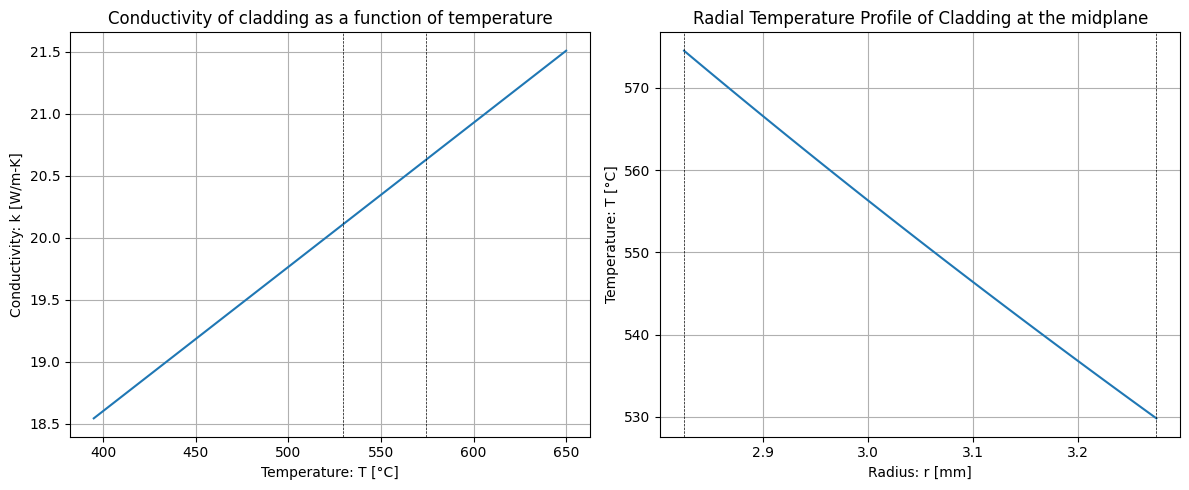

In [35]:
# RADIAL TEMPERATURE PROFILE OF CLADDING AT MIDPLANE

# Cladding thickness guess value
t_clad_i0 = 0.45 #[mm] Initial guess of cladding thickness

# Geometry of cladding
r_clad_out = D_clad_out/2 #[mm] External radius of cladding
r_clad_in = r_clad_out - t_clad_i0 #[mm] Internal radius of cladding

# Outer cladding temperature
T_co_avg0 = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of coolant along the channel
T_clad_out0_K = q_l0*1e3 / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_avg0 #[K] Outer cladding temperature
T_clad_out0 = T_clad_out0_K - 273.15
print(f'Outer cladding temperature at the midplane (T_clad_out0): {T_clad_out0:.2f} [°C]')

# Inner temperature of cladding
T_clad_in0 = T_clad_out0 + 50  #[°C] Initial guess for inner temperature of the cladding at midplane

for _ in range(1000):
    T_clad_avg0 = (T_clad_in0 + T_clad_out0) / 2 #[°C] Average temperature of the clading at midplane
    k_clad_avg0 = 13.95 + 0.01163 * T_clad_avg0 #[W/m-K] Thermal conductivity of cladding
    T_clad_in0_new = T_clad_out0 + (q_l0 * 1e3 * np.log(r_clad_out / r_clad_in)) / (2 * np.pi * k_clad_avg0) #[°C] i-th iteration for inner temperature of the cladding

    if abs(T_clad_in0_new - T_clad_in0) < 0.1:  # Check for convergence
        break
    T_clad_in0 = T_clad_in0_new #[°C] Update outlet temperature of coolant

print(f"Inner cladding temperature at the midplane (T_clad_in0): {T_clad_in0:.2f} [°C]")
print(f"Average conductivity of the cladding at the midplane (k_clad_avg0): {k_clad_avg0:.2f} [W/m-K]")

# Radial temperature profile of the cladding at the midplane
def T_clad_r0(r_clad):
    C = T_clad_out0 + (q_l0 * 1e3 * np.log(r_clad_out)) / (2 * np.pi * k_clad_avg0)
    return -(q_l0 * 1e3 * np.log(r_clad)) / (2 * np.pi * k_clad_avg0) + C

# Inner cladding temperature at midplane
T_clad_in0v = T_clad_r0(r_clad_in)
print(f'Inner cladding temperature at the midplace (verification): {T_clad_in0v:.2f} [°C]')

# Define range of values for graph cladding conductivity vs temperature
T_clad_values = np.linspace(T_co_in_C, 650, 100)
k_clad_values = 13.95 + 0.01163 * T_clad_values #[W/m-K] Thermal conductivity of cladding

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_clad_values, k_clad_values)
ax1.set_title('Conductivity of cladding as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_clad_in0, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_clad_out0, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph cladding temperature vs radius
r_clad_values = np.linspace(r_clad_in, r_clad_out, 100)  #values along cladding thickness
T_clad_values = T_clad_r0(r_clad_values)

# Plot the results
ax2.plot(r_clad_values, T_clad_values)
ax2.set_title('Radial Temperature Profile of Cladding at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_clad_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Outer gap temperature at the midplane: 574.43 [°C]
Inner gap temperature at the midplane (T_gap_in0): 1190.79 [°C]
Average conductivity of the gap at the midplane (k_gap_avg0): 0.42 [W/m-K]
Inner gap temperature at the midplace (verification): 1190.86 [°C]


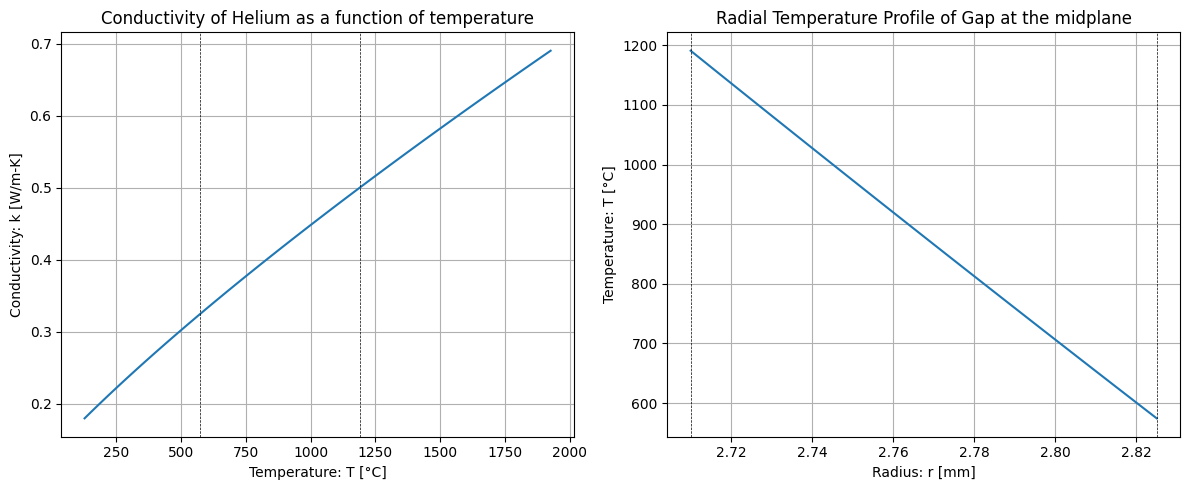

In [36]:
# RADIAL TEMPERATURE PROFILE OF GAP AT MIDPLANE

# Define constants
T_gap_out0_C = T_clad_in0 #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel_out/2 #[mm] Inner radius of the gap
T_gap_out0_K = T_gap_out0_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the midplane: {T_gap_out0_C:.2f} [°C]')

# Inner temperature of gap
T_gap_in0_K = T_gap_out0_K + 50  #[K] Initial guess for the inner temperature of the gap at midplane

for _ in range(1000):
    T_gap_avg0 = (T_gap_in0_K + T_gap_out0_K) / 2 #[K] Average temperature of the gap at the midplane
    k_He_avg0 = 15.8e-4 * T_gap_avg0**0.79 #[W/m-K] Average thermal conductivity of filling gas at midplane
    T_gap_in0_K_new = T_gap_out0_K + (q_l0 * 1e3 * np.log(r_gap_out / r_gap_in)) / (2 * np.pi * k_He_avg0) #[K] i-th iteration for inner temperature of the gap

    if abs(T_gap_in0_K_new - T_gap_in0_K) < 0.1:  # Check for convergence
        break
    T_gap_in0_K = T_gap_in0_K_new #[K] Update inner temperature of gap

T_gap_in0_C = T_gap_in0_K - 273.15 #[°C] Inner temperature of the gap at the midplane

print(f"Inner gap temperature at the midplane (T_gap_in0): {T_gap_in0_C:.2f} [°C]")
print(f"Average conductivity of the gap at the midplane (k_gap_avg0): {k_He_avg0:.2f} [W/m-K]")

# Radial temperature profile of the gap at the midplane
def T_gap_K_r0(r_gap):
    C = T_gap_out0_K + (q_l0 * 1e3 * np.log(r_gap_out)) / (2 * np.pi * k_He_avg0)
    return -(q_l0 * 1e3 * np.log(r_gap)) / (2 * np.pi * k_He_avg0) + C

# Inner cladding temperature at midplane
T_gap_in0_Cv = T_gap_K_r0(r_gap_in) - 273.15 #[°C] Verification of inner temperature of the gap at the midplane
print(f'Inner gap temperature at the midplace (verification): {T_gap_in0_Cv:.2f} [°C]')

# Define range of values for graph gap conductivity vs temperature
T_gap_values = np.linspace(400, 2200, 100) #[K]
k_gap_values = 15.8e-4 * T_gap_values**0.79 #[W/m-K] Thermal conductivity of filling gas at different temperatures

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_gap_values-273.15, k_gap_values)
ax1.set_title('Conductivity of Helium as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_gap_in0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_gap_out0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph gap temperature vs radius
r_gap_values = np.linspace(r_gap_in, r_gap_out, 100)  #values along cladding thickness
T_gap_C_values = T_gap_K_r0(r_gap_values) - 273.15 #[°C]

# Plot the results
ax2.plot(r_gap_values, T_gap_C_values)
ax2.set_title('Radial Temperature Profile of Gap at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Maximum temperature at external wall of cladding: 636.62 [°C] at H = 558.48 (out of the active section) [mm]
Maximum temperature at internal wall of cladding: 648.54 [°C] at H = 434.46 (out of the active section) [mm]
Maximum temperature at the midwall of the cladding: 639.12 [°C] at H = 495.85 (out of the active section) [mm]
Temperature of coolant at midplane: 515.38 [°C]
Outer wall temperature of cladding at midplane: 529.83 [°C]
Inner wall temperature of cladding at midplane: 572.31 [°C]


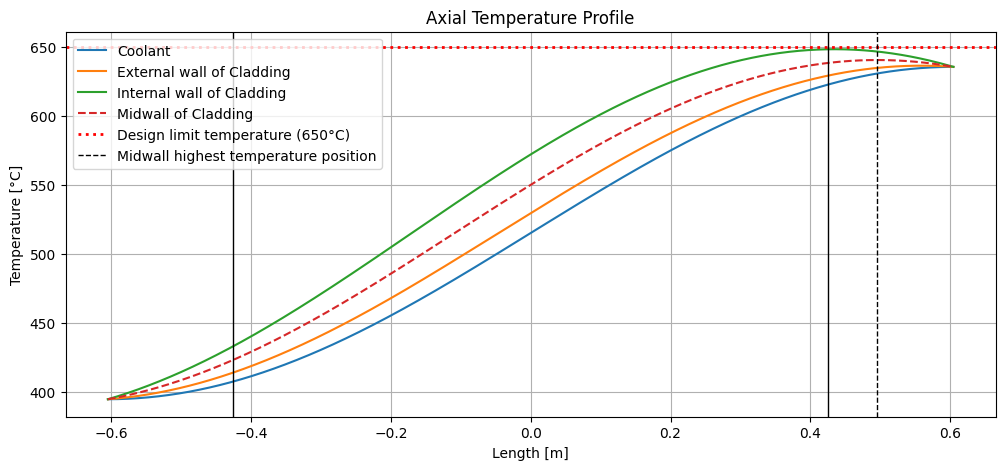

In [37]:
# AXIAL TEMPERATURE PROFILE OF CLADDING AND COOLANT

# Define midwall position
r_clad_mw = (r_clad_in + r_clad_out)/2 #[mm] Midwall position of the cladding

# Define axial temperature profile of the coolant
def T_co_z(z):
    C = T_co_in_C - q_l0/2 * 1e3 * np.sin(- np.pi / 2) * H_ext / (m_co_in * cp_co_avg * np.pi)
    return q_l0 * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (2 * m_co_in * cp_co_avg * np.pi) + C #[°C] The heat transferred is the half of one pin

# Define axial temperature profile of the outer wall of the cladding
def T_clad_out_z(z):
    return q_l0*1e3 * np.cos(np.pi * z / H_ext) / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_z(z)

# Define average conductivity of the cladding
k_clad_out_avg = 13.95 + 0.01163 * (T_clad_out_z(-H_act/2) + 650)/2

# Define axial temperature profile of the cladding as a function of radial position
def T_clad_z(r_clad, z):
    return T_clad_out_z(z) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_out/r_clad)  / (2*np.pi * k_clad_out_avg)

# Define the range of z_clad values
z_values = np.linspace(-H_ext/2, H_ext/2, 1000)  #[m]

# Calculate the axial temperature profiles
T_co_values = T_co_z(z_values)
T_clad_out_values = T_clad_out_z(z_values)
T_clad_in_values = T_clad_z(r_clad_in, z_values)
T_clad_mw_values = T_clad_z(r_clad_mw, z_values)

# Calculate the maximum temperature
T_clad_out_res = minimize_scalar(lambda z: - T_clad_out_z(z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_max = T_clad_out_z(T_clad_out_res.x)
T_clad_in_res = minimize_scalar(lambda z: - T_clad_z(r_clad_in, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_in_max = T_clad_z(r_clad_in,T_clad_in_res.x)
T_clad_mw_res = minimize_scalar(lambda z: - T_clad_z(r_clad_mw, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_mw_max = T_clad_z(r_clad_mw,T_clad_in_res.x)
print(f'Maximum temperature at external wall of cladding: {T_clad_out_max:.2f} [°C] at H = {T_clad_out_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at internal wall of cladding: {T_clad_in_max:.2f} [°C] at H = {T_clad_in_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at the midwall of the cladding: {T_clad_mw_max:.2f} [°C] at H = {T_clad_mw_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Temperature of coolant at midplane: {T_co_z(0):.2f} [°C]')
print(f'Outer wall temperature of cladding at midplane: {T_clad_out_z(0):.2f} [°C]')
print(f'Inner wall temperature of cladding at midplane: {T_clad_z(r_clad_in, 0):.2f} [°C]')

# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values, T_co_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values, T_clad_out_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_in_values, label = 'Internal wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_mw_values, label = 'Midwall of Cladding', ls = '--')  # r_fuel is already in mm
plt.title('Axial Temperature Profile')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axhline(650, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (650°C)')
plt.axvline(T_clad_mw_res.x, color = 'black', linestyle = '--', linewidth = 1.0, label ='Midwall highest temperature position')
plt.axvline(-H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.axvline(H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.legend()
plt.grid()
plt.show()

Outer gap temperature at the top of the active length (estimated hottest point for the fuel): 648.50 [°C]
Inner gap temperature at the top of the active length (T_gap_in): 1240.08 [°C]
Average conductivity of the gap at the top of the active length (k_gap_avg): 0.43 [W/m-K]
Inner gap temperature at the top of the active length (verification): 1240.12 [°C]


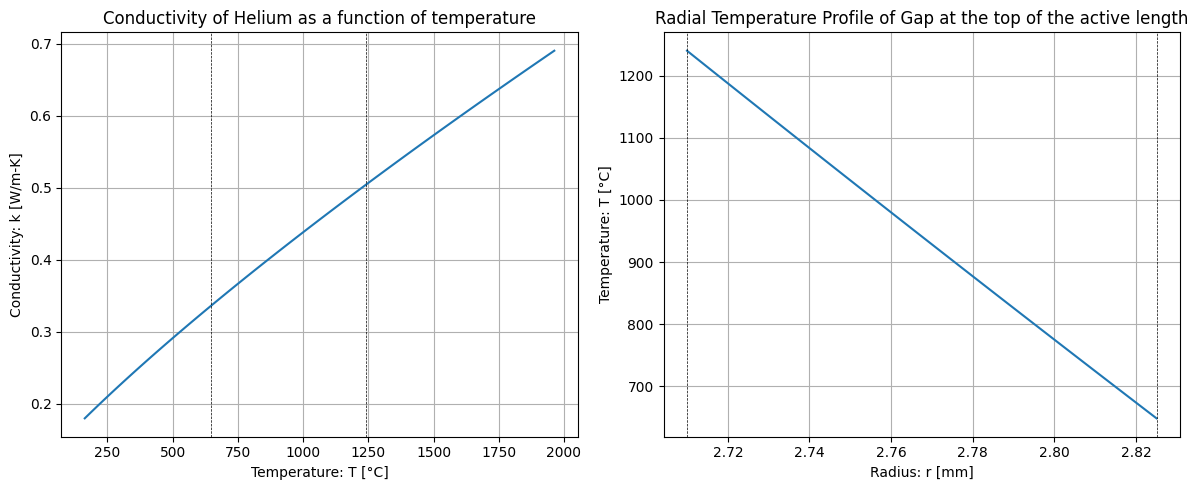

In [38]:
# RADIAL TEMPERATURE PROFILE OF GAP AT THE END OF THE ACTIVE LENGTH (HOTTEST POINT)

# Define constants
T_gap_out_max_C = T_clad_z(r_clad_in, H_act/(2*1000)) #[°C] Outer temperature of the gap at cladding side
T_gap_out_max_K = T_gap_out_max_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the top of the active length (estimated hottest point for the fuel): {T_gap_out_max_C:.2f} [°C]')

# Inner temperature of gap
T_gap_in_max_K = T_gap_out_max_K + 50  #[K] Initial guess for the inner temperature of the gap at midplane

for _ in range(1000):
    T_gap_avg_max = (T_gap_in_max_K + T_gap_out_max_K) / 2 #[K] Average temperature of the gap at the top of the active length
    k_He_avg_max = 15.8e-4 * T_gap_avg_max**0.79 #[W/m-K] Average thermal conductivity of filling gas at midplane
    T_gap_in_max_K_new = T_gap_out_max_K + (q_l0 * 1e3 * np.log(r_gap_out / r_gap_in)) / (2 * np.pi * k_He_avg_max) #[K] i-th iteration for inner temperature of the gap

    if abs(T_gap_in_max_K_new - T_gap_in_max_K) < 0.1:  # Check for convergence
        break
    T_gap_in_max_K = T_gap_in_max_K_new #[K] Update inner temperature of gap

T_gap_in_max_C = T_gap_in_max_K - 273.15 #[°C] Inner temperature of the gap at the top of the active length

print(f"Inner gap temperature at the top of the active length (T_gap_in): {T_gap_in_max_C:.2f} [°C]")
print(f"Average conductivity of the gap at the top of the active length (k_gap_avg): {k_He_avg_max:.2f} [W/m-K]")

# Radial temperature profile of the gap at the top of the active length
def T_gap_K_r_max(r_gap):
    C = T_gap_out_max_K + (q_l0 * 1e3 * np.log(r_gap_out)) / (2 * np.pi * k_He_avg_max)
    return -(q_l0 * 1e3 * np.log(r_gap)) / (2 * np.pi * k_He_avg_max) + C

# Inner cladding temperature at the top of the active length
T_gap_in_max_Cv = T_gap_K_r_max(r_gap_in) - 273.15 #[°C] Verification of the gap temperature
print(f'Inner gap temperature at the top of the active length (verification): {T_gap_in_max_Cv:.2f} [°C]')

# Define range of values for graph gap conductivity vs temperature
T_gap_max_values = np.linspace(400, 2200, 100) #[K]
k_gap_max_values = 15.8e-4 * T_gap_max_values**0.79 #[W/m-K] Thermal conductivity of filling gas at different temperatures

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_gap_max_values-237.15, k_gap_max_values)
ax1.set_title('Conductivity of Helium as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_gap_in_max_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_gap_out_max_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph gap temperature vs radius
T_gap_max_C_values = T_gap_K_r_max(r_gap_values) - 273.15 #[°C]

# Plot the results
ax2.plot(r_gap_values, T_gap_max_C_values)
ax2.set_title('Radial Temperature Profile of Gap at the top of the active length')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The thermal conductivity of the fuel changes with change in temperature with the following relation:

\begin{equation}
\int_{T_{fo}}^{T(r)}k(T)dT = \frac{q'}{4π}*(1-(\frac{r}{r_{fo}})^2)
\end{equation}

Using the relations provided in the pdf, k(T) is given by:
\begin{equation}
k(T) = 1.755+(k_0-1.755)*exp(\frac{β}{128.15})
\end{equation}

\begin{equation}
k_0(T) = (\frac{1}{A+B*T(K)} + \frac{D}{T^2(K)}*exp(\frac{E}{T(K))}))*(1-p)^2
\end{equation}

\begin{equation}
A=0.01926+1.06*10^{-6}*x +2.63*10^{-8}
\end{equation}

\begin{equation}
B=2.39*10^{-4} + 1.37*10^{-13}
\end{equation}

\begin{equation}
D=5.27*10^{9}
\end{equation}

\begin{equation}
E=17109.5
\end{equation}

The term x used in A is the deviation	from	stoichiometry and is calculated as:
\begin{equation}
x=2-O/M
\end{equation}

Takin all of the previous equations into account, and solving the integral we get an equation that cannot be solved analytically, but only numerically.

\begin{equation}
1.755(T(r)-T_1)(1-e^x)+(1-p)^{2.5}(\frac{ln(B*T(r)+A)}{B}-\frac{ln(B*T_{fo})+A)}{B}+D*\frac{e^{-E/T(r)}-e^{-E/T_{fo}}}{E}) = \frac{q'}{4π}(1-(\frac{r}{r_{fo}})^2)
\end{equation}

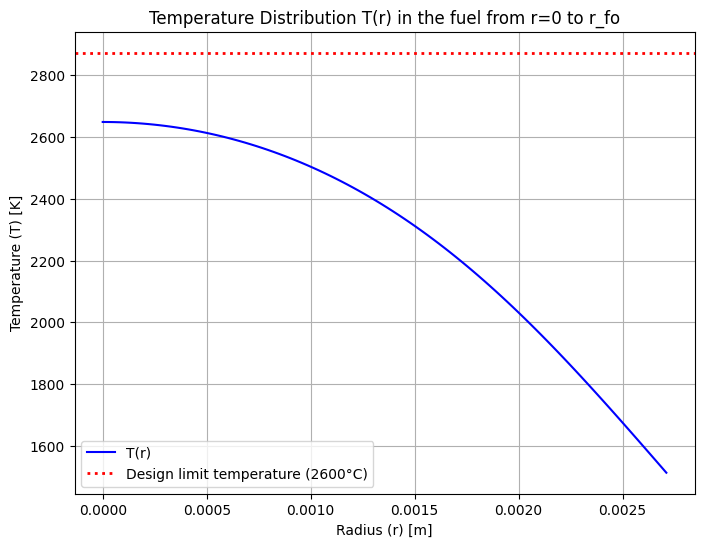

In [39]:
# RADIAL TEMPERATURE PROFILE OF FUEL AT THE END OF THE ACTIVE LENGTH (HOTTEST POINT)

# Input parameters
r_fuel_out = r_gap_in * 1e-3  #[m] Radius of fuel pellet
T_fuel_out_max = T_gap_in_max_K  #[K] Estimated maximum outer fuel temperature
p = 0.055 #[/] porosity
x = 0.043
D = 5.27e9
E = 17109.5

# Calculate A and B based on provided formulas
A = 0.01926 + 1.06e-6 * x + 2.63e-8
B = 2.39e-4 + 1.37e-13
exponent = beta/128.75

# Constants
q_prime_over_4pi = q_l0 * 1e3/ (4 * np.pi)
p_factor = (1 - p)**2.5
exp_factor_1 = np.exp(-E / T_fuel_out_max)

# Define the function to solve for T(r) at each r
def equation_to_solve(T_r, r):
    # Left-hand side of the equation minus the right-hand side (LHS - RHS = 0)
    term1 = 1.755 * (T_r - T_fuel_out_max) * (1 - np.exp(-exponent))  # Assuming x = -r as a function of r
    term2 = p_factor * ((np.log(B * T_r + A) - np.log(B * T_fuel_out_max + A)) / B +
                        D * (np.exp(-E / T_r) - exp_factor_1) / E)
    lhs = term1 + term2
    rhs = q_prime_over_4pi * (1 - (r / r_fuel_out)**2)
    return lhs - rhs

# Range of r values from r1 to 0
r_fuel_values = np.linspace(r_fuel_out, 0, 100)
T_fuel_values = [] #[K]

# Solve for T(r) for each value of r using an initial guess of T1
initial_guess = T_fuel_out_max
for r in r_fuel_values:
    T_r_solution = fsolve(equation_to_solve, initial_guess, args=(r))[0]
    T_fuel_values.append(T_r_solution)
    initial_guess = T_r_solution  # Update initial guess for smoother convergence

# Plotting T(r) vs r
plt.figure(figsize=(8, 6))
plt.plot(r_fuel_values, T_fuel_values, label="T(r)", color='blue')
plt.xlabel("Radius (r) [m]")
plt.ylabel("Temperature (T) [K]")
plt.title("Temperature Distribution T(r) in the fuel from r=0 to r_fo")
plt.axhline(2600+273.15, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.legend()
plt.grid(True)  # Invert x-axis to show r from r1 to 0
plt.show()

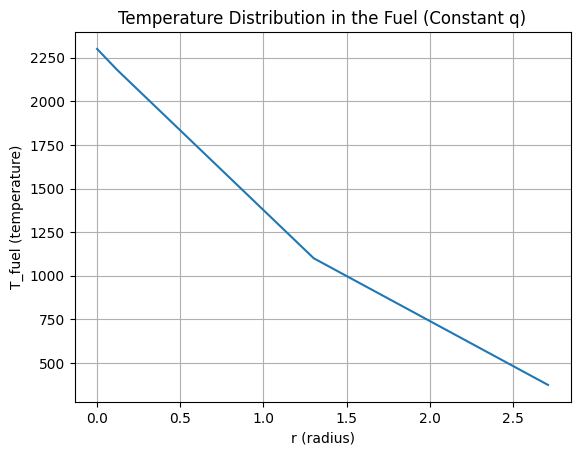

In [40]:
# RADIAL TEMPERATURE PROFILE AT MIDPLANE






# FUEL TEMPERATURE PROFILE

D_fuel_out = 5.42 #[mm] Fuel pellet outer diameter
q_fuel = (38.7*0.85)/(np.pi*D_fuel_out/1000) #[kW/m^2] Nodalization of heat along the z-axis of the fuel

# Define constants
A = 0.01926 + 1.06e-6*1 + 2.63e-8*1
B = 2.39e-4 + 1.37e-13*1
D = 5.27e9
E = 17109.5
beta = 56 #burnup
p = 0.05 #porosity

# Define functions for A and B
#def A(x):
#    return 0.01926 + 1.06e-6 * x + 2.63e-8

#def B(x):
#    return 2.39e-4 + 1.37e-13

# Define k_fuel as a function of T_fuel
def k_fuel(T_fuel):
    k_0 = (1 / (A + B * T_fuel) + D / (T_fuel**2) * np.exp(-E / T_fuel)) * (1 - p)**2.5
    return 1.755 + (k_0 - 1.755) * np.exp(-beta / 128.75)

# Differential equation: dq/dr = -k_fuel * dT_fuel/dr
def dT_dr(r, T_fuel):
    return -q_fuel / k_fuel(T_fuel)

# Parameters for the problem
#x = 0.01  # Example parameter value for A and B

# Initial condition
T_fuel_0 = 2300  # Example initial temperature at r=0

# Radius range
r_span = (0, D_fuel_out/2)  # From r=0 to r=10

# Solve the ODE numerically
solution = solve_ivp(dT_dr, r_span, [T_fuel_0], r_eval=np.linspace(0, D_fuel_out/2, 100))

# Plot the results
plt.plot(solution.t, solution.y[0])
plt.xlabel('r (radius)')
plt.ylabel('T_fuel (temperature)')
plt.title('Temperature Distribution in the Fuel (Constant q)')
plt.grid(True)
plt.show()


In [41]:
# AXIAL TEMPERATURE PROFILE OF GAP

# Axial temperature profile of the gap at the midplane
def T_gap_K_z(r_gap):
    C = (2*T_gap_out0_K)**1.79 + (1.79*2**0.79) * (q_l0 * 1e3 * r_clad_out * np.log(r_gap_out)) / (2 * np.pi * (r_clad_out/1000) * 15.8e-4)
    return (- (1.79*2**0.79) * (q_l0 * 1e3 * r_clad_out * np.log(r_gap)) / (2 * np.pi * (r_clad_out/1000) * 15.8e-4) + C)**(1/1.79) - T_gap_out0_K